In [2]:
#!/usr/bin/env python
# coding: utf-8

from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd

##########################################################################################
''' Marker list '''
marker_list = ['d', 'o', 'x', 'v', '^', '<', '>', 's', '8', 'p']

''' Linewidth '''
lw = 5

''' Color list '''
## Manually set color list
# color_list = ["blue", "orange", "green", "purple", "brown", "#FBDD7E", "cyan", "#C20078", "#FAC205", "gray",  "#06C2AC", "#FFFF14", "#E6DAA6","olive", "#76FF7B", "pink", "#BC8F6", "#AAA662"]
## Tableau color list
color_dict = mcolors.TABLEAU_COLORS
color_list = list()
for name in color_dict:
    color_list.append(color_dict[name])

''' Line style '''
line_style_list = ["solid", "dashdot", "dashed", 'dotted']
##########################################################################################

routing_algorithm = ["RoundRobin-LCLB", "RoundRobin-MCLB", "RoundRobin-heuristic_TE"]
cluster_id = [0, 1]


In [3]:


def plot_latency_cdf(latency_dict_):
    fig = plt.figure()
    color_idx = 0
    ls_idx = 0
    for key in latency_dict_:
        x_0 = np.sort(latency_dict_[key])
        num_data_point_0 = len(latency_dict_[key])
        y_0 = np.arange(num_data_point_0) / float(num_data_point_0)
        plt.plot(x_0, y_0, label=key, color=color_list[color_idx], linewidth=lw, linestyle=line_style_list[ls_idx])
        color_idx += 1
        ls_idx += 1
    # plt.title("cluster", fontsize=30)
    plt.xlim(0, )
    plt.xlabel('Request latency(ms)', fontsize=30)
    plt.ylabel('CDF', fontsize=25)
    # plt.legend(loc="lower right", fontsize=14, frameon = False)
    plt.legend(loc="lower right", fontsize=16)
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
    # plt.savefig(path+workload+"-"+cluster_name+"-latency_cdf.pdf", dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    

def find_tail_idx(data, tail=0.95):
    tail_idx = 0
    for i in range(len(data)):
        if data[i] >= tail:
            tail_idx = i
            break
    print("{}, tail_idx: {}".format("???", tail_idx))
    return tail_idx
    
def plot_tail_latency_cdf(latency_dict_):
    fig = plt.figure()     
    color_idx = 0
    ls_idx = 0
    for key in latency_dict_:
        num_data_point_0 = len(latency_dict_[key])
        y_0 = np.arange(num_data_point_0) / float(num_data_point_0)
        tail = 0.95
        tail_idx = find_tail_idx(y_0, tail)
        y_tail = y_0[tail_idx:]
        x_0 = np.sort(latency_dict_[key])
        x_tail = x_0[tail_idx:]
        plt.plot(x_tail, y_tail, label=key, color=color_list[color_idx], linewidth=lw, linestyle=line_style_list[ls_idx])
        color_idx += 1
        ls_idx += 1
    # plt.title("Bursty cluster", fontsize=30)
    plt.xlim(0, )
    plt.xlabel('Request latency(ms)', fontsize=30)
    plt.ylabel('CDF', fontsize=25)
    # plt.legend(loc="lower right", fontsize=14, frameon = False)
    plt.legend(loc="lower right", fontsize=16)
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
    # plt.savefig(path+workload+"-"+cluster_name+"-tail_latency_cdf.pdf", dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    
def parse_latency_file(f_):
    data = f_.readlines()
    latency = list()
    for elem in data:
        latency.append(float(elem.strip()))
    return latency

def latency_file_to_df(f_):
    df = pd.read_csv(f_, header=None)
    df.columns=["request_latency"]
    df = df.sort_values(by=["request_latency"])
    df = df.reset_index(drop="True")
    return df


def print_statistics(latency_dict_):
    for key in latency_dict_:
        print("="*30)
        print(key)
        print("- Avg: {}".format(round(np.mean(latency_dict_[key]), 2)))
        print("- 50p: {}".format(round(np.percentile(latency_dict_[key], 50), 2)))
        print("- 90p: {}".format(round(np.percentile(latency_dict_[key], 90), 2)))
        print("- 95p: {}".format(round(np.percentile(latency_dict_[key], 95), 2)))
        print("- 99p: {}".format(round(np.percentile(latency_dict_[key], 99), 2)))
        print("- 99.9p: {}".format(round(np.percentile(latency_dict_[key], 99.9), 2)))

def plot_quantile(ser):
    q_list = [0.5, 0.9, 0.95, 0.99, 0.999]
    # q_list = [0.5, 0.9, 0.95, 0.99]
    quantiles = list()
    for q in q_list:
        temp = int(ser.quantile(q))
        quantiles.append(temp)
        print("{}: {}".format(str(q), temp))
    return quantiles

def parse_metadata(path):
    f_ = open(path, 'r')
    lines = f_.readlines()
    application = lines[0].split(":")[-1].strip()
    load_balancer = lines[1].split(":")[-1].strip()
    routing = lines[2].split(":")[-1].strip()
    return application, load_balancer, routing

def plot_latency(common_path):
    c0_files = list()
    c1_files = list()
    metadata_files = list()
    for routing in routing_algorithm:
        metad = common_path + routing + "/metadata.txt"
        c0_f_ = common_path + routing + "/latency-cluster_0.txt"
        c1_f_ = common_path + routing + "/latency-cluster_1.txt"
        c0_files.append(c0_f_)
        c1_files.append(c1_f_)
        metadata_files.append(metad)
        try:
            assert c0_f_.split(".")[-1] == "txt" and c0_f_.split("/")[-1].split("-")[0] == "latency"
            assert c1_f_.split(".")[-1] == "txt" and c1_f_.split("/")[-1].split("-")[0] == "latency"
        except:
            print("invalid file name: {}".format(c0_f_))
            print("invalid file name: {}".format(c1_f_))
            exit()

    latency_files = [c0_files, c1_files]
    qt_list = list()
    cdf_list = list()
    for cid in cluster_id:
        for i in range(len(routing_algorithm)):
            file_ = open(latency_files[cid][i], 'r')
            df = latency_file_to_df(file_)
            print("{}, {}".format("Cluster"+str(cid), routing_algorithm[i]))
            qt_list.append(plot_quantile(df["request_latency"]))
            cdf = df['request_latency'].value_counts().sort_index().cumsum() / len(df)
            cdf_list.append(cdf)

    fig = plt.figure(figsize=(8, 7))
    subplot_pos = 0

    q_ = [[0.5, 0.90], [0.95, 0.995]]
    for i_ in range(len(q_)):
        idx=0
        for cid in cluster_id:
            xmin = list()
            xmax = list()
            ax1 = fig.add_subplot(2,2, subplot_pos+1) # (row, col, the position of the current plot)
            for routing in routing_algorithm:
                cdf_list[idx].plot(kind='line', label=routing)
                xmin.append(np.percentile(cdf_list[idx].index, q_[i_][0]*100))
                xmax.append(np.percentile(cdf_list[idx].index, q_[i_][1]*100))
                idx+=1
            sorted_numbers = sorted(xmax, reverse=True)
            if (sorted_numbers[0] / sorted_numbers[1]) > 8:
                xm = (sorted_numbers[0] + sorted_numbers[1])/(sorted_numbers[0] / sorted_numbers[1])*4
            else:
                xm = max(xmax)
            fig.suptitle(common_path, fontsize=10)
            ax1.set_xlim(min(xmin)-100, xm+100)
            ax1.set_ylim(q_[i_][0], q_[i_][1]+0.001)
            ax1.tick_params(axis='y', labelsize=10)
            ax1.tick_params(axis='x', labelsize=10)
            ax1.set_xlabel('Request latency(ms)', fontsize=10)
            ax1.set_ylabel('CDF', fontsize=10)
            ax1.legend(loc="lower right", fontsize=10)
            ax1.set_title("Cluster"+str(cid) + ", " + str(q_[i_][0]), fontsize=10)
            subplot_pos += 1
    fig.tight_layout()
    plt.show()
    plt.close()

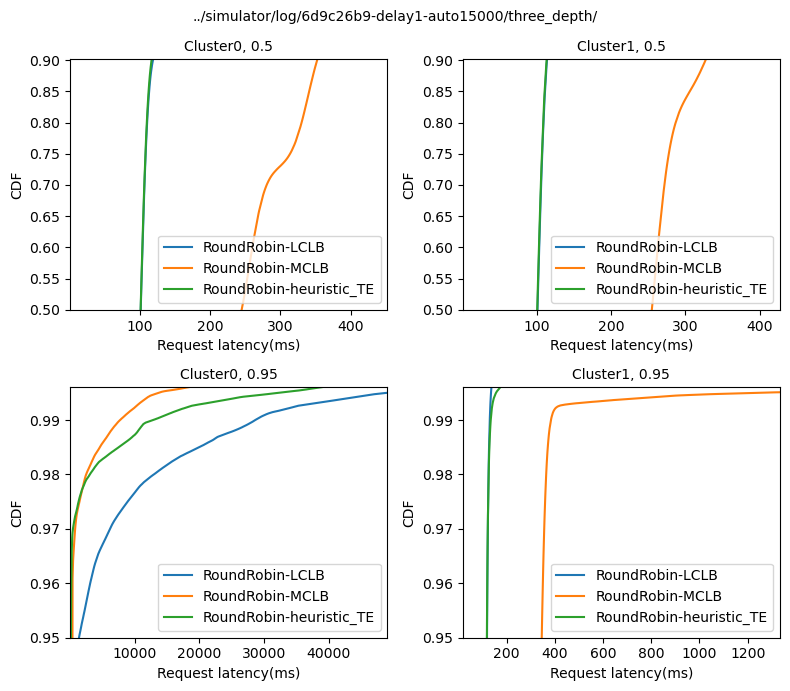

In [4]:
common_path="../simulator/log/6d9c26b9-delay1-auto15000/three_depth/"
plot_latency(common_path)

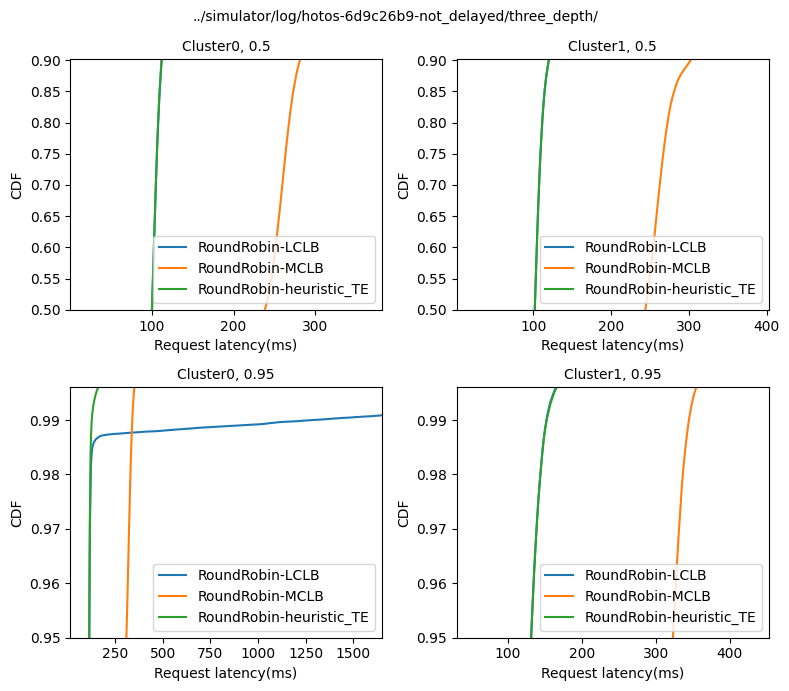

In [18]:
common_path="../simulator/log/hotos-6d9c26b9-not_delayed/three_depth/"
plot_latency(common_path)

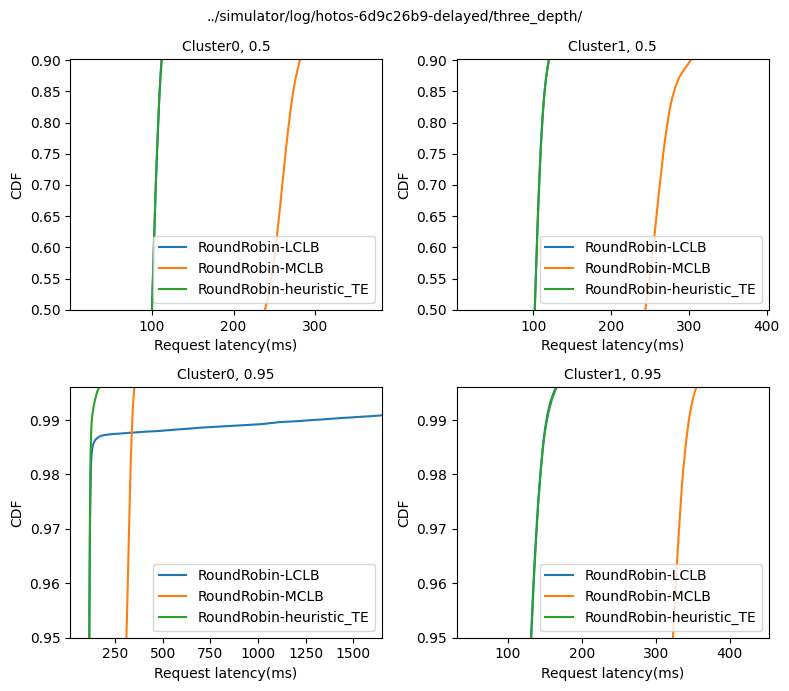

In [17]:
common_path="../simulator/log/hotos-6d9c26b9-delayed/three_depth/"
plot_latency(common_path)

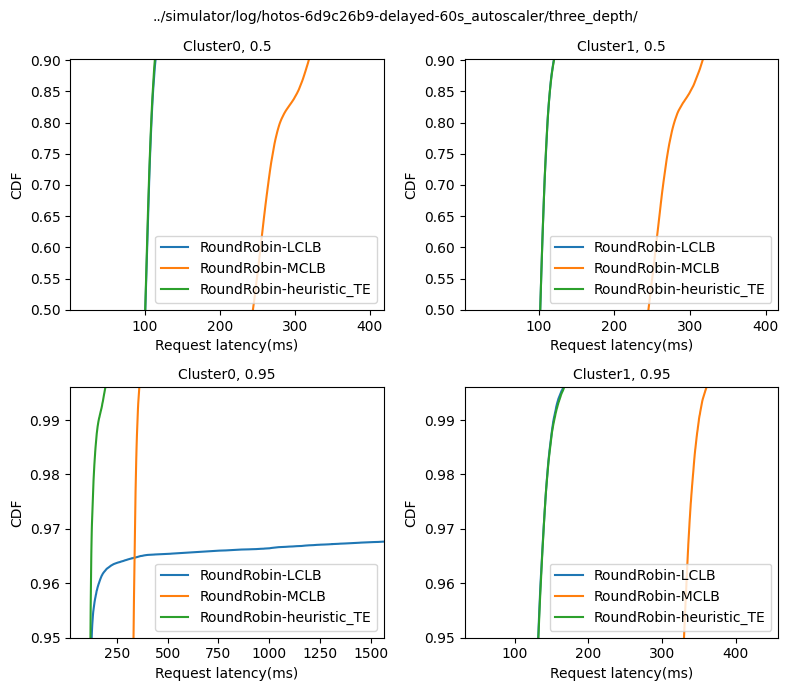

In [13]:
common_path="../simulator/log/hotos-6d9c26b9-delayed-60s_autoscaler/three_depth/"
plot_latency(common_path)

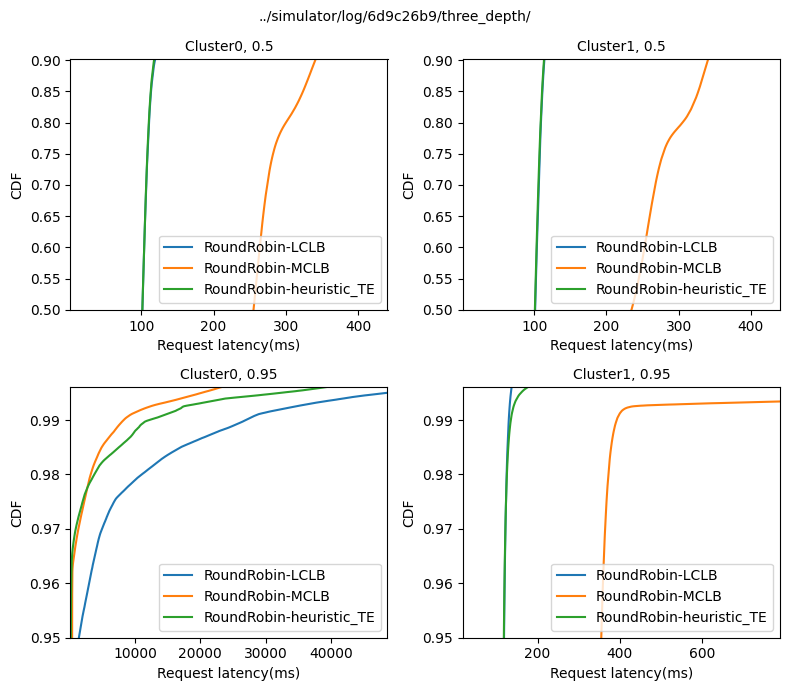

In [20]:
common_path="../simulator/log/6d9c26b9/three_depth/"
plot_latency(common_path)

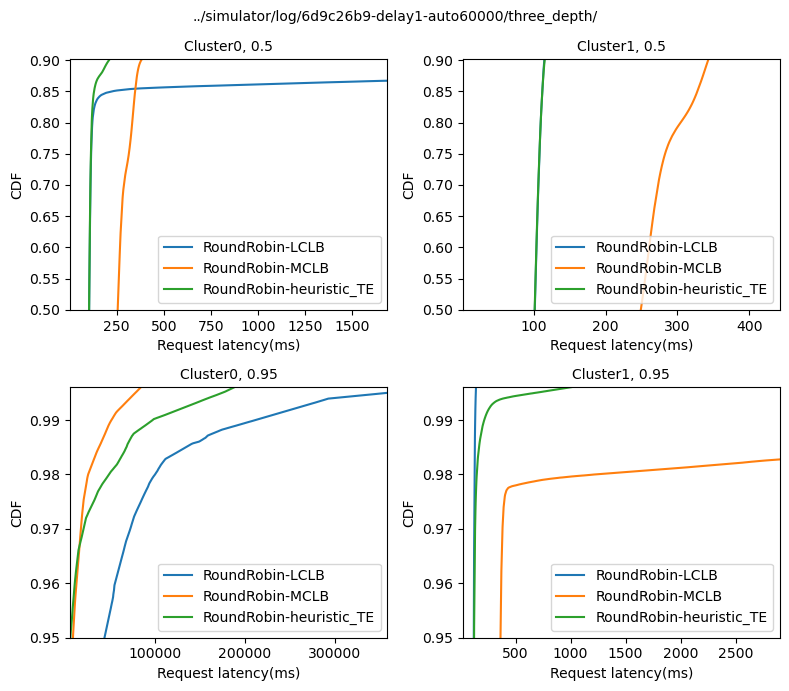

In [5]:
common_path="../simulator/log/6d9c26b9-delay1-auto60000/three_depth/"
plot_latency(common_path)

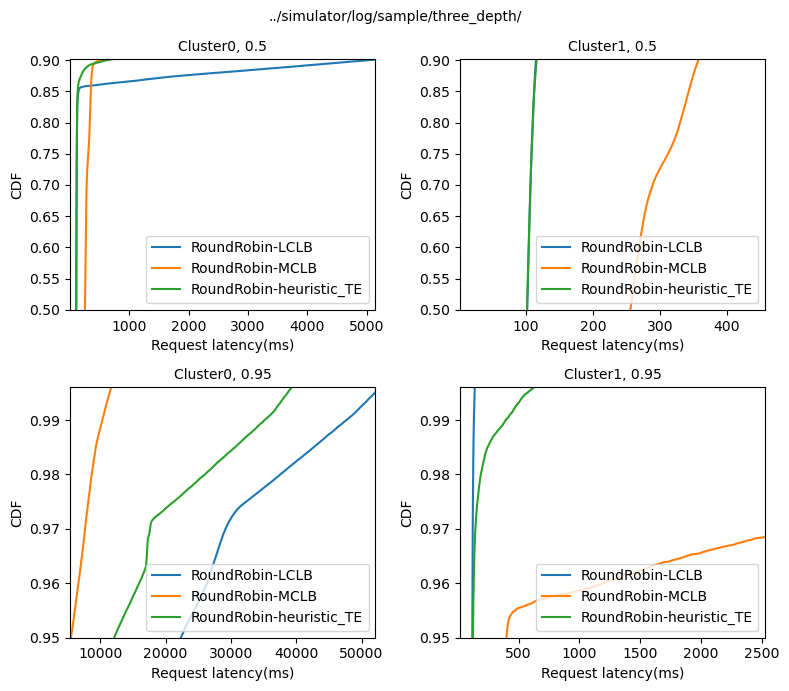

In [5]:
common_path="../simulator/log/sample/three_depth/"
plot_latency(common_path)

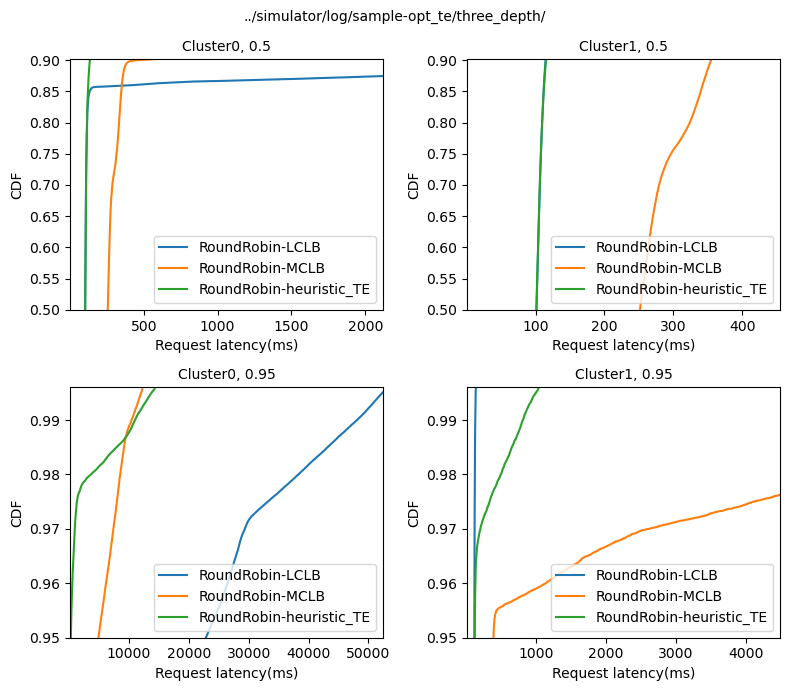

In [4]:
common_path="../simulator/log/sample-opt_te/three_depth/"
plot_latency(common_path)

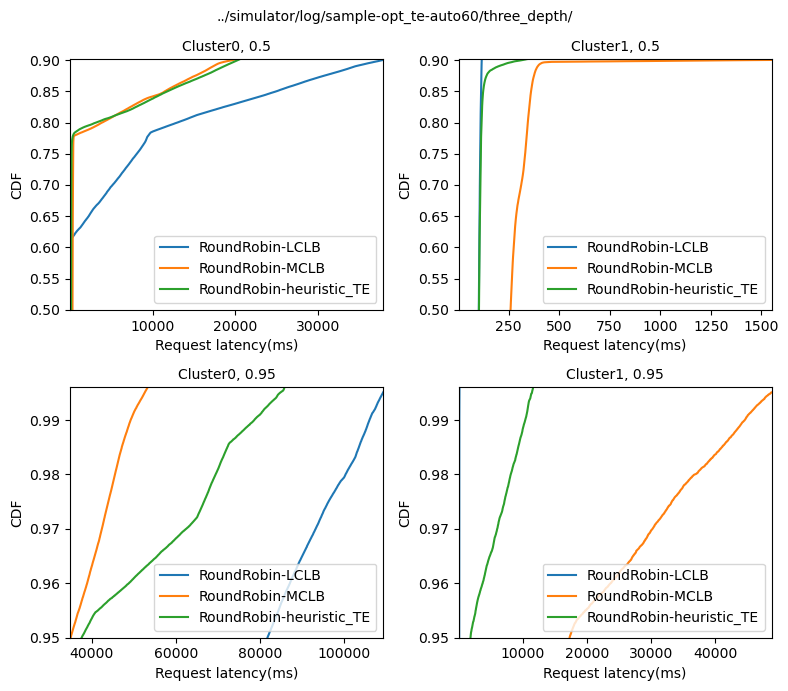

In [6]:
common_path="../simulator/log/sample-opt_te-auto60/three_depth/"
plot_latency(common_path)

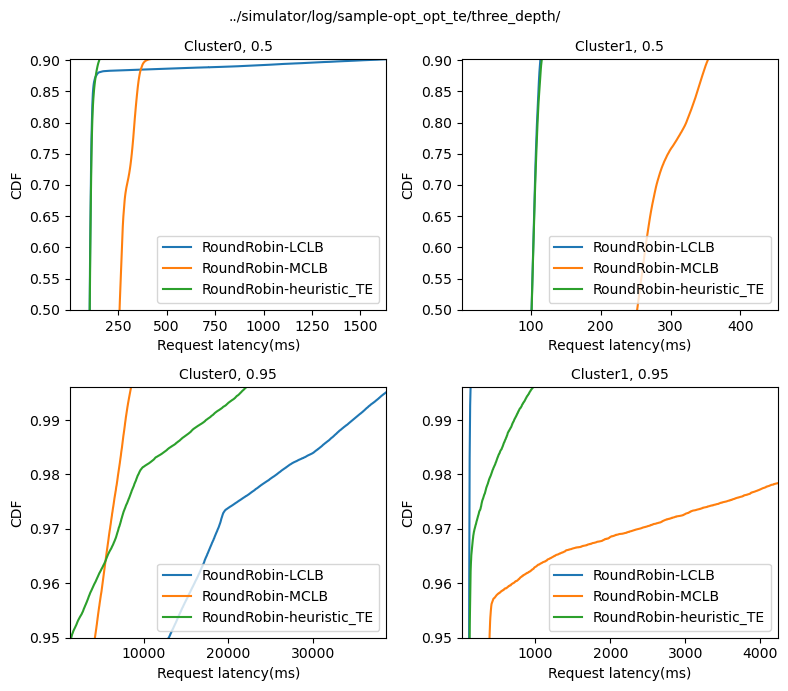

In [7]:
common_path="../simulator/log/sample-opt_opt_te/three_depth/"
plot_latency(common_path)

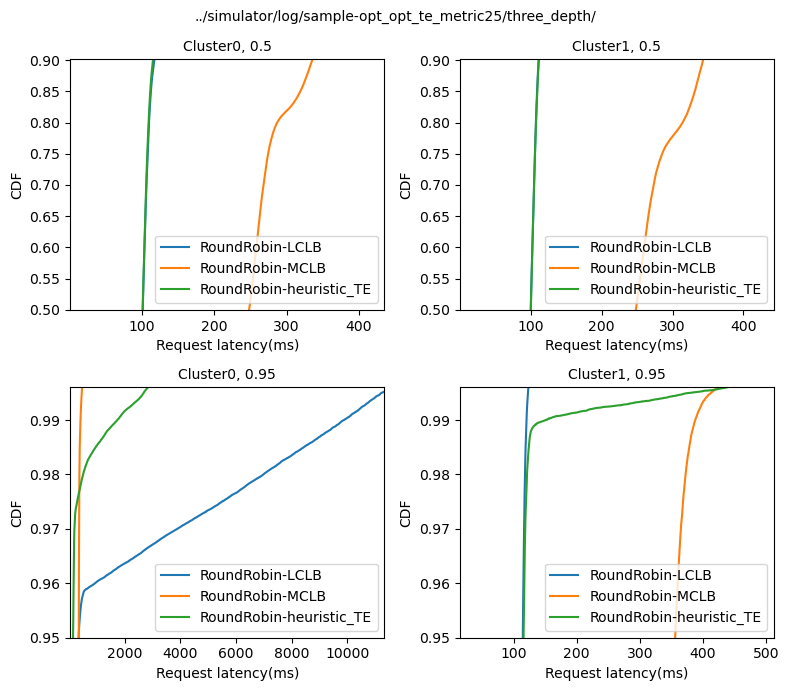

In [9]:
common_path="../simulator/log/sample-opt_opt_te_metric25/three_depth/"
plot_latency(common_path)

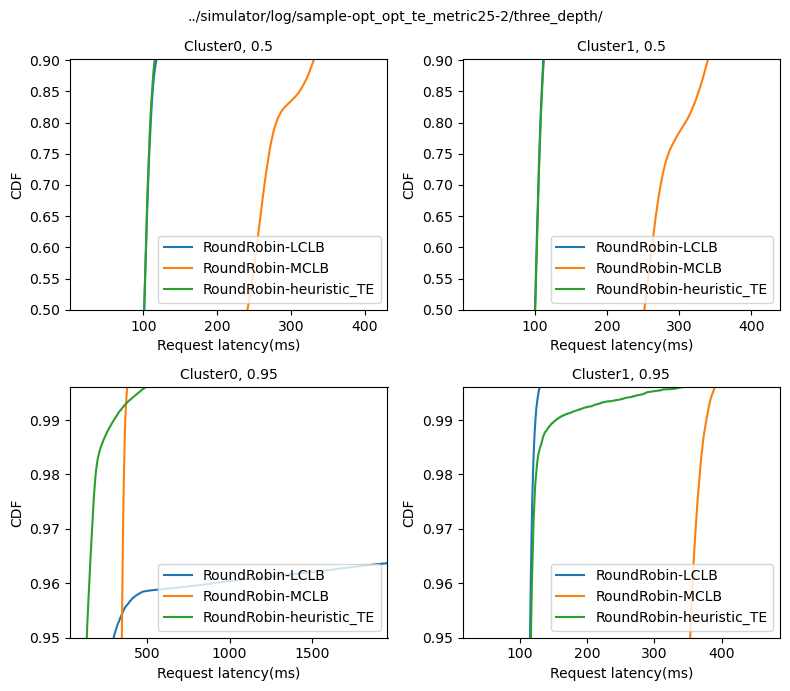

In [10]:
common_path="../simulator/log/sample-opt_opt_te_metric25-2/three_depth/"
plot_latency(common_path)